<center> <h1> Natural Language Processing - IMDB movie reviews </h1> </center>

### Importing Libraries

In [22]:
import pandas as pd
import nltk
import re
import string
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS

### Reading CSV file

In [23]:
df = pd.read_csv('./Datasets/NLP_reviews.csv')

In [24]:
#import stopwords
stopword = nltk.corpus.stopwords.words('english')

#import Lemmatizer
wn = nltk.WordNetLemmatizer()

In [25]:
#visualizing wordcloud
def show_wordcloud(data, title = None):
    
    wordcloud = WordCloud(background_color = 'white', max_words = 200, max_font_size = 40, scale = 3, random_state = 42).generate(str(data))

    fig = plt.figure(1, figsize = (20, 20))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize = 20)
        fig.subplots_adjust(top = 2.3)

    plt.imshow(wordcloud)
    plt.show()

### Visualizations

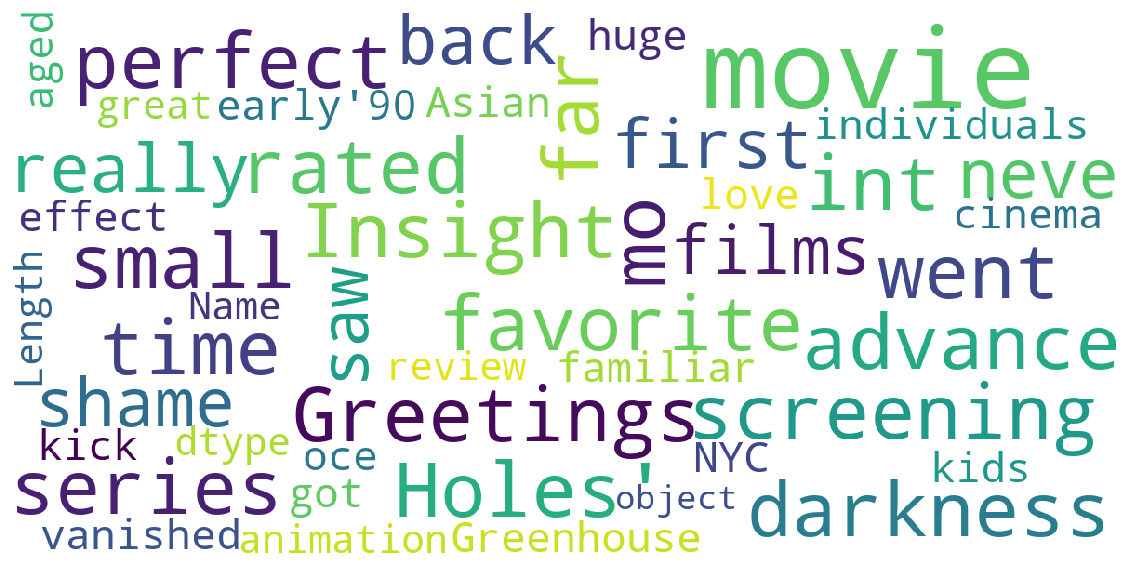

In [26]:
#Positive words for wordcloud
pos = df[df['sentiment']=='Positive']
show_wordcloud(pos['review'])

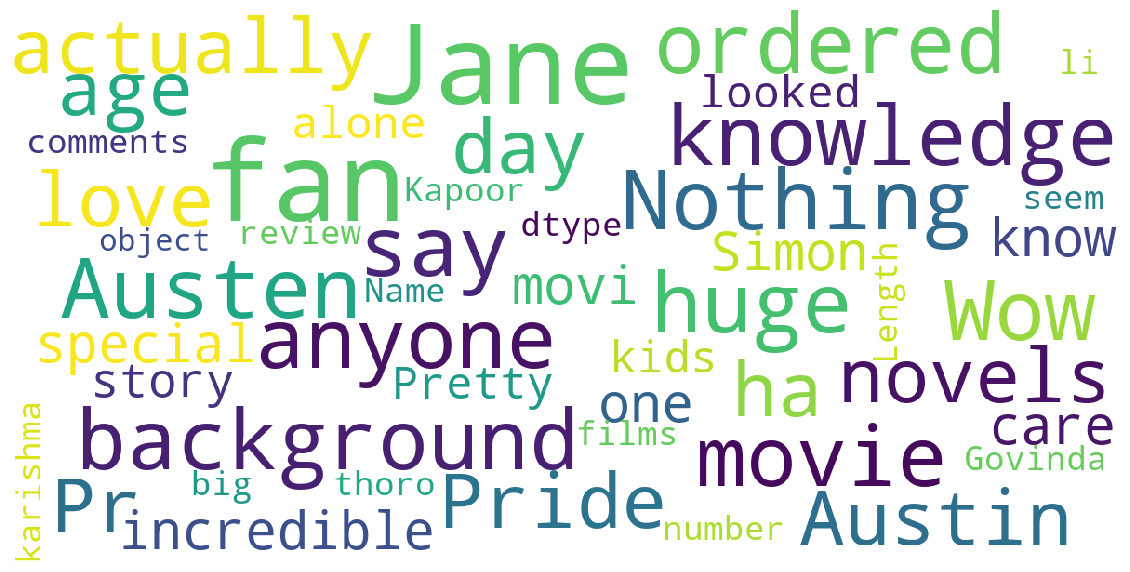

In [27]:
#Negative words for wordcloud
neg = df[df['sentiment']=='Negative']
show_wordcloud(neg['review'])

### Feature Engineering

In [28]:
#Add body length to dataframe
df['body_len'] = df['review'].apply(lambda x:len(x) - x.count(" "))

C:\Users\urvi1\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  after removing the cwd from sys.path.
C:\Users\urvi1\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  """


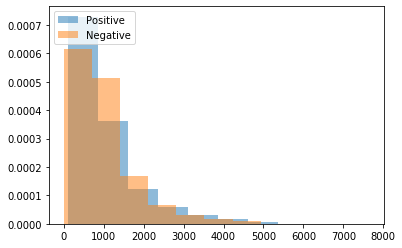

In [29]:
#Visualizing body_length
%matplotlib inline

plt.hist(df[df['sentiment']=='Positive']['body_len'], alpha = 0.5, normed = True, label = 'Positive')
plt.hist(df[df['sentiment']=='Negative']['body_len'], alpha = 0.5, normed = True, label = 'Negative')
plt.legend(loc = "upper left")
plt.show()

#since the graph is much interconnected, we can say that this feature is not useful for distinguishing positive from negative

In [30]:
#Dropping the body length column
df.drop(columns = ['body_len'])

,sentiment,review
0,Negative,I had no background knowledge of this movie be...
1,Negative,I am a huge Jane Austen fan and I ordered the ...
2,Negative,Nothing to say but Wow! Has anyone actually ha...
3,Negative,i like Jane Austin novels. I love Pride and Pr...
4,Negative,In this day and age of incredible special movi...
...,...,...
9995,Positive,I first saw this movie back in the early'90's ...
9996,Positive,"NYC, 2022: The Greenhouse effect, vanished oce..."
9997,Positive,"Those individuals familiar with Asian cinema, ..."
9998,Positive,"The kids, aged 7 to 14, got such a huge kick o..."


In [31]:
#checking count of values
df['sentiment'].value_counts()

Negative    5081
Positive    4919
Name: sentiment, dtype: int64

### Data Cleaning

In [32]:
#data cleaning
def cleanedData(text):
    #no punctuations
    text = text.lower()
    nopunctext = "".join([char for char in text if char not in string.punctuation])
    #tokenize
    tokens = re.split('\W+',nopunctext)
    #no stopwords
    nostopwords = [word for word in tokens if word not in stopword]
    #Lemmatizing
    cleaned = [wn.lemmatize(word) for word in nostopwords]
    #Lemmatizing for N-grams
    #cleaned = "".join([wn.lemmatize(word) for word in nostopwords])
    return cleaned

In [33]:
# #calling clean function
# df['cleaned_text'] = df[ 'review'].apply(lambda x:cleanedData(x.lower()))

### Vectorizing

In [34]:
#vectorizing using TFIDF
tfidfvect = TfidfVectorizer(analyzer = cleanedData)
tvectorized = tfidfvect.fit_transform(df['review'])
print(tvectorized.shape)
tfidf_df = pd.DataFrame(tvectorized.toarray())
tfidf_df.columns = tfidfvect.get_feature_names()
# print(tfidf_df)

(10000, 64438)


In [35]:
# #vectorizing using CountVectorizer
# cvvect = CountVectorizer(analyzer = cleanedData)
# cvectorized = cvvect.fit_transform(df['review'])
# print(cvectorized.shape)
# cv_df = pd.DataFrame(cvectorized.toarray())
# cv_df.columns = cvvect.get_feature_names()
# print(cv_df)

In [36]:
# #vectorizing using N-gram
# cvvect = CountVectorizer(analyzer = cleanedData, ngram_range = (1,2))
# cvectorized = cvvect.fit_transform(df['review'])
# print(cvectorized.shape)
# cv_df = pd.DataFrame(cvectorized.toarray())
# cv_df.columns = cvvect.get_feature_names()
# print(cv_df)

### Splitting train, validation and test data set

In [37]:
#Separating X and Y values
Y = df['sentiment']
X = tfidf_df

In [38]:
#Splitting dataset
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.1, random_state = 100)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.3, random_state = 100)

### Machine Learning

In [39]:
#Importing Libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import roc_curve, auc

In [40]:
#Random Forest Classifier
def train_rf(n_est, depth):
    rf = RandomForestClassifier(n_estimators = n_est, max_depth = depth, n_jobs = -1)
    rf_model = rf.fit(x_train, y_train)
    y_pred = rf_model.predict(x_val)
    precision, recall, fscore, support = score(y_val, y_pred, pos_label = 'Positive', average = 'binary')
    print('Est: {}, Depth: {} ----- Precision: {}, Recall: {}, Accuracy: {}'.format(n_est, depth, round(precision, 3), round(recall, 3),
                                                                                   round((y_pred==y_val).sum()/len(y_pred), 3)))

for n_est in [150, 200, 300]:
    for depth in [None, 60, 90]:
        train_rf(n_est,depth)

Est: 150, Depth: None ----- Precision: 0.831, Recall: 0.801, Accuracy: 0.824
Est: 150, Depth: 60 ----- Precision: 0.844, Recall: 0.8, Accuracy: 0.831
Est: 150, Depth: 90 ----- Precision: 0.828, Recall: 0.81, Accuracy: 0.826
Est: 200, Depth: None ----- Precision: 0.846, Recall: 0.8, Accuracy: 0.832
Est: 200, Depth: 60 ----- Precision: 0.843, Recall: 0.802, Accuracy: 0.831
Est: 200, Depth: 90 ----- Precision: 0.835, Recall: 0.819, Accuracy: 0.833
Est: 300, Depth: None ----- Precision: 0.839, Recall: 0.811, Accuracy: 0.833
Est: 300, Depth: 60 ----- Precision: 0.848, Recall: 0.805, Accuracy: 0.835
Est: 300, Depth: 90 ----- Precision: 0.84, Recall: 0.801, Accuracy: 0.829


Output:

Est: 150, Depth: None ----- Precision: 0.857, Recall: 0.794, Accuracy: 0.827
Est: 150, Depth: 60 ----- Precision: 0.866, Recall: 0.799, Accuracy: 0.834
Est: 150, Depth: 90 ----- Precision: 0.853, Recall: 0.791, Accuracy: 0.824
Est: 200, Depth: None ----- Precision: 0.864, Recall: 0.795, Accuracy: 0.832
Est: 200, Depth: 60 ----- Precision: 0.865, Recall: 0.806, Accuracy: 0.837
Est: 200, Depth: 90 ----- Precision: 0.865, Recall: 0.789, Accuracy: 0.829
Est: 300, Depth: None ----- Precision: 0.865, Recall: 0.808, Accuracy: 0.838
Est: 300, Depth: 60 ----- Precision: 0.868, Recall: 0.799, Accuracy: 0.835
Est: 300, Depth: 90 ----- Precision: 0.869, Recall: 0.804, Accuracy: 0.838
1
#Random Forest Classifier with Cross Validation

In [41]:
#Random Forest Classifier with Cross Validation
rf1 = RandomForestClassifier(n_estimators = 300, max_depth = 90, n_jobs = -1)
k_fold = KFold(n_splits = 5)
cross_val_score(rf1, x_train, y_train, cv = k_fold, scoring = 'accuracy', n_jobs = -1)

array([0.83730159, 0.83730159, 0.84761905, 0.84603175, 0.82936508])

Output:

array([0.84047619, 0.83333333, 0.83571429, 0.84761905, 0.82936508])

In [42]:
#Prediction on test dataset
test_model = rf1.fit(x_train, y_train)
test_pred = test_model.predict(x_test)
precision, recall, fscore, support = score(y_test, test_pred, pos_label = 'Positive', average = 'binary')
print('Precision: {}, Recall: {}, Accuracy: {}'.format(round(precision, 3), round(recall, 3), 
                                                       round((y_test==test_pred).sum()/len(test_pred), 3)))

Precision: 0.83, Recall: 0.837, Accuracy: 0.836


Output:

Precision: 0.83, Recall: 0.837, Accuracy: 0.836